In [168]:
from typing import Callable
from collections import namedtuple
from copy import deepcopy as dc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from tqdm import tqdm

##### слои

###### линейный

In [169]:
LR = 0.0015
GAMMA = 0.9
BETA1 = 0.9
BETA2 = 0.999
ALPHA = 0.05
DP = 0.4


class NNLinear:
    wb: np.ndarray
    inputs: np.ndarray
    optimizer_name: str

    nag_v: np.ndarray = None  # type: ignore
    adagrad_G: np.ndarray = None  # type: ignore
    adam_t: int = None  # type: ignore
    adam_m: np.ndarray = None  # type: ignore
    adam_v: np.ndarray = None  # type: ignore

    dropout_mask: np.ndarray = None  # type: ignore

    def __init__(self, in_len, out_len, optimizer_name, perceptron):
        self.wb = np.random.rand(in_len+1, out_len)-0.5
        self.optimizer_name = optimizer_name
        self.perceptron = perceptron

    def __repr__(self):
        return f'NNLinear({self.wb.shape})'

    def __eq__(self, o):
        return id(self) == id(o)

    def forward(self, inputs: np.ndarray):
        # if self.dropout_mask is None or np.random.uniform() > 0.8 or 1:
        self.dropout_mask = np.random.choice(
            a=[False, True], size=self.wb.shape, p=[DP, 1-DP])

        self.inputs = np.append(inputs, [1])
        return self.inputs @ (self.wb*self.dropout_mask)

    def backward(self, grad):
        grad_to_ret = (grad @ (self.wb*self.dropout_mask).T)[:-1]
        grad_wb = np.reshape(self.inputs, (-1, 1)) @ np.reshape(grad, (1, -1))

        grad_wb = grad_wb * self.dropout_mask

        if np.linalg.norm(grad_wb) != 0:
            grad_wb = grad_wb/np.linalg.norm(grad_wb)

        d = list()
        match self.optimizer_name:
            case 'SGD':
                d = grad_wb  # type:ignore

                if np.linalg.norm(d) > 0.001:
                    d = LR * d / np.linalg.norm(d)

            case 'Adam':
                if self.adam_t is None:
                    self.adam_t = 0
                    self.adam_m = np.zeros(self.wb.shape)
                    self.adam_v = np.zeros(self.wb.shape)
                self.adam_t += 1
                self.adam_m = BETA1*self.adam_m + \
                    (1-BETA1)*grad_wb    # type:ignore
                self.adam_v = BETA2*self.adam_v + \
                    (1-BETA2)*grad_wb**2  # type:ignore
                m = self.adam_m/(1-BETA1**self.adam_t)  # type:ignore
                v = self.adam_v/(1-BETA2**self.adam_t)  # type:ignore
                d = m/np.sqrt(v + 10e-8)  # type:ignore

                if np.linalg.norm(d) > 0.001:
                    d = LR * d / np.linalg.norm(d)

            case _:
                raise RuntimeError('unknown optimizing method')

        self.wb -= d

        # L2
        l2_reg = ALPHA*LR*self.wb
        self.wb -= l2_reg

        return grad_to_ret

###### функции

In [170]:
relu = np.vectorize(lambda x: x if x > 0 else 0)
der_relu = np.vectorize(lambda x: 1 if x > 0 else 0)


class NNRelu:
    inputs: np.ndarray

    def forward(self, inputs):
        self.inputs = inputs
        return relu(inputs)

    def backward(self, grad):
        res = grad * der_relu(self.inputs)
        return res


def sigmoid(x): return 1/(1+np.exp(-x))
def der_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))


class NNSigmoid:
    inputs: np.ndarray

    def forward(self, inputs):
        self.inputs = inputs
        return sigmoid(inputs)

    def backward(self, grad):
        res = grad * der_sigmoid(self.inputs)
        return res

In [171]:
def softmax(x):
    if np.linalg.norm(x) < 0.001:
        return np.zeros(len(x))
    x = x / np.linalg.norm(x)
    return np.exp(x)/(np.exp(x)).sum() if (np.exp(x)).sum() > 0.01 else np.zeros(len(x))


class NNSoftmax:
    inputs: np.ndarray

    def forward(self, inputs):
        self.inputs = inputs
        return softmax(inputs)

    def backward(self, grad):
        res = grad * softmax(self.inputs)*(1-softmax(self.inputs))
        return res

###### лосс

In [172]:
LossFunc = namedtuple('LossFunc', ['f', 'df', 'name'])

In [173]:
def mse(x, y): return sum((x-y)**2)/len(x)
def der_mse(x, y): return (x-y)*2/len(x)*-1


MSE = LossFunc(mse, der_mse, 'MSE LOSS')

In [174]:
def cross_entropy(target, pred):
    pred = np.clip(pred, 1e-15, 1 - 1e-15)
    return -sum(target * np.log(pred) - (1 - target) * np.log(1 - pred))


def der_cross_entropy(target, pred):
    pred = np.clip(pred, 1e-15, 1 - 1e-15)
    return - (target / pred) + (1 - target) / (1 - pred)


CrossEntropy = LossFunc(cross_entropy, der_cross_entropy, 'Cross Entropy LOSS')

###### модель

In [175]:
class Perceptron:
    layers: list
    loss: LossFunc
    last_target: np.ndarray | None

    def __init__(self, sizes: list[int], loss, optimizer):
        self.layers = [
            x for i, o in zip(sizes, sizes[1:]+[10]) for x in [NNLinear(i, o, optimizer, self), NNSigmoid()]
        ] + [NNSoftmax()]
        self.loss = loss

    def forward(self, inputs):
        res = inputs
        for layer in self.layers:
            res = layer.forward(res)
        return res

    def backward(self, target, pred):
        grad_by_last_layer_outs = self.loss.df(target, pred)
        grad = grad_by_last_layer_outs
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

    def fit(self, x, y):
        self.last_target = y
        pred = self.forward(x)
        self.backward(y, pred)
        return np.argmax(pred)

    def predict(self, x, y):
        pred = self.forward(x)
        return np.argmax(pred)

###### данные

In [176]:
ds = datasets.MNIST(
    root='data',
    train=True,
    download=True,

    transform=lambda img: np.array(np.asarray(img).flatten())/256,
    target_transform=lambda x: np.array(
        [1 if i == x else 0 for i in range(10)])
)
dl = {
    'test': DataLoader(Subset(ds, range(0, 200)), shuffle=True, batch_size=None),
    'train': DataLoader(Subset(ds, range(200, 300)), shuffle=True, batch_size=None),
}

##### Тренируем

###### функции тренировки

In [177]:
def run_epoch(model, train=False):
    results = 0
    d = dl['train'] if train else dl['test']
    for X, y in d:
        X, y = np.array(X), np.array(y)
        if train:
            pred = model.fit(X, y)
        else:
            pred = model.predict(X, y)
        results += (np.argmax(y) == pred)
    return results/len(d)


def train_many_epochs(model, N):
    global LR
    train_ac = []
    test_ac = []

    for i in tqdm(range(N)):
        if i == 30:
            LR = LR*0.65
        a = run_epoch(model, True)
        b = run_epoch(model, False)
        # print(a, b)
        train_ac.append(a)
        test_ac.append(b)

    plt.plot(range(1, N+1), train_ac, label='train')
    plt.plot(range(1, N+1), test_ac, label='test')
    plt.legend()
    plt.show()

    print(f'train best: {max(train_ac)}')
    print(f'test best:  {max(test_ac)}')
    print(f'alpha = {ALPHA}')
    print(f'dp = {DP}')

    return train_ac

###### тренировка

In [178]:
SGD = 'SGD'
NAG = 'NAG'
ADAGRAD = 'Adagrad'
ADAM = 'Adam'


def demo(optim: str, epochs: int = 20, samples: int = 500):
    global LR, GAMMA, BETA1, BETA2, dl

    match optim:
        case 'SGD':
            LR = 0.065
        case 'NAG':
            LR = 0.0065
            GAMMA = 0.95
        case 'Adagrad':
            LR = 0.015
        case 'Adam':
            LR = 0.0065
            GAMMA = 0.9
            BETA1 = 0.9
            BETA2 = 0.99

    dl = {
        'test': DataLoader(Subset(ds, range(0, samples)), shuffle=True, batch_size=None),
        'train': DataLoader(Subset(ds, range(int(samples), int(samples*1.1))), shuffle=True, batch_size=None),
    }

    p = Perceptron(
        [784] + [128, 128] + [10],
        CrossEntropy,
        optim
    )
    print(f'optimiser is {optim}')
    train_many_epochs(p, epochs)

###### без регуляризации

optimiser is SGD


100%|██████████| 50/50 [15:56<00:00, 19.12s/it]


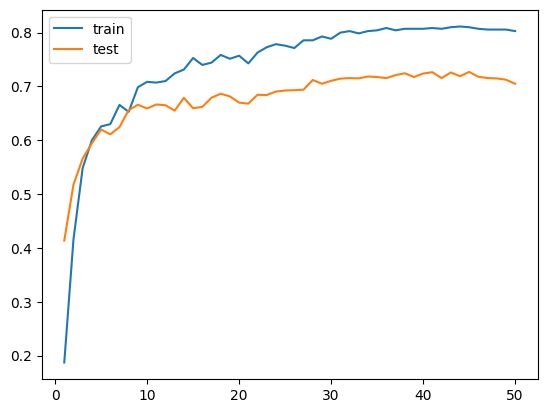

train best: 0.8114285714285714
test best:  0.727
alpha = 0
dp = 0


In [179]:
ALPHA = 0
DP = 0
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [15:46<00:00, 18.92s/it]


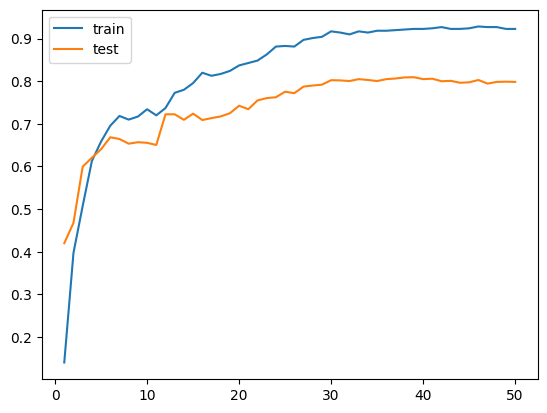

train best: 0.9285714285714286
test best:  0.8095
alpha = 0
dp = 0


In [180]:
ALPHA = 0
DP = 0
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [11:02<00:00, 13.24s/it]


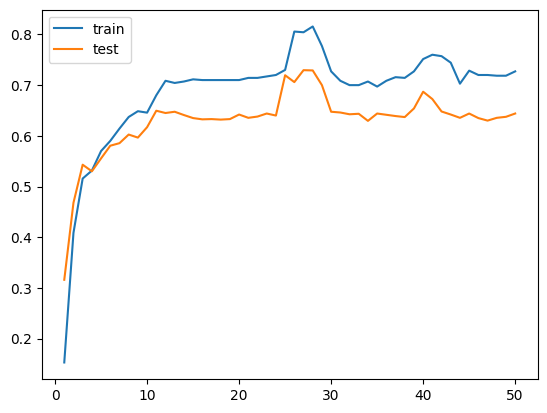

train best: 0.8157142857142857
test best:  0.7295
alpha = 0
dp = 0


In [181]:
ALPHA = 0
DP = 0
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


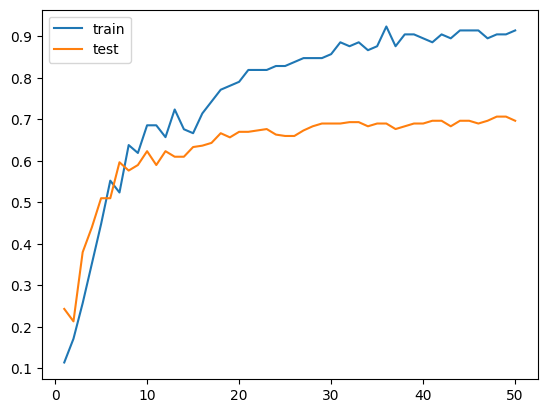

train best: 0.9238095238095239
test best:  0.7066666666666667
alpha = 0
dp = 0


In [182]:
ALPHA = 0
DP = 0
demo(SGD, samples=300, epochs=50)

###### эксперименты с L2

optimiser is SGD


100%|██████████| 50/50 [10:58<00:00, 13.18s/it]


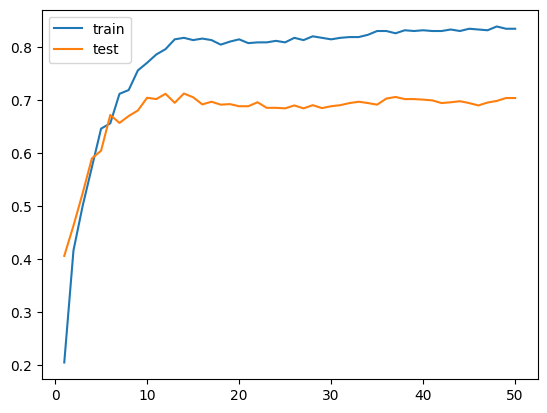

train best: 0.8385714285714285
test best:  0.712
alpha = 5e-05
dp = 0


In [183]:
ALPHA = 5e-5
DP = 0
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [10:44<00:00, 12.89s/it]


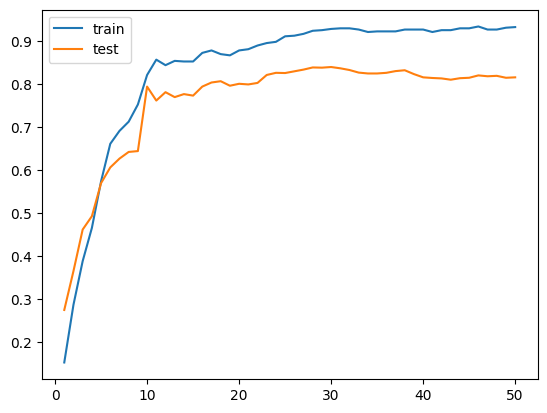

train best: 0.9342857142857143
test best:  0.84
alpha = 0.0005
dp = 0


In [184]:
ALPHA = 5e-4
DP = 0
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [10:56<00:00, 13.14s/it]


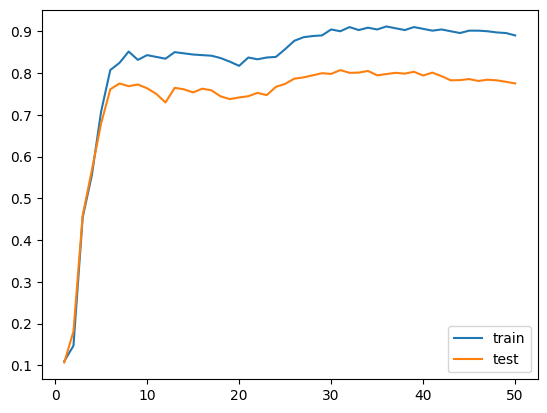

train best: 0.9114285714285715
test best:  0.807
alpha = 5e-06
dp = 0


In [185]:
ALPHA = 5e-6
DP = 0
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [10:53<00:00, 13.08s/it]


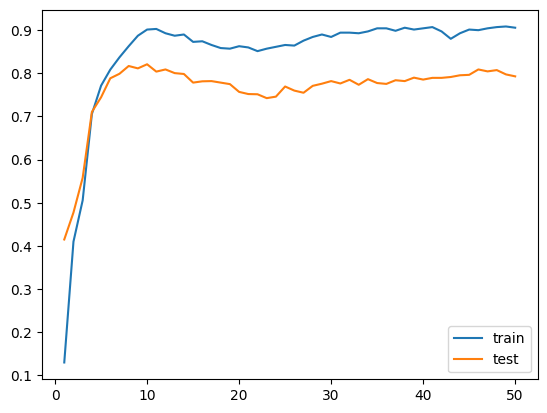

train best: 0.9085714285714286
test best:  0.821
alpha = 0.005
dp = 0


In [186]:
ALPHA = 5e-3
DP = 0
demo(SGD, samples=2000, epochs=50)

###### эксперименты с дропаутом

optimiser is SGD


100%|██████████| 50/50 [11:02<00:00, 13.25s/it]


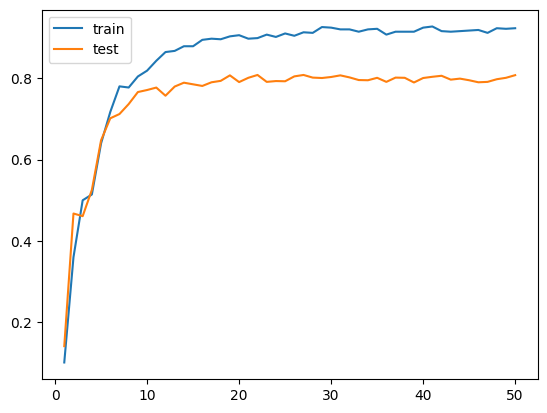

train best: 0.9271428571428572
test best:  0.808
alpha = 0
dp = 0.05


In [187]:
ALPHA = 0
DP = 0.05
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [11:09<00:00, 13.39s/it]


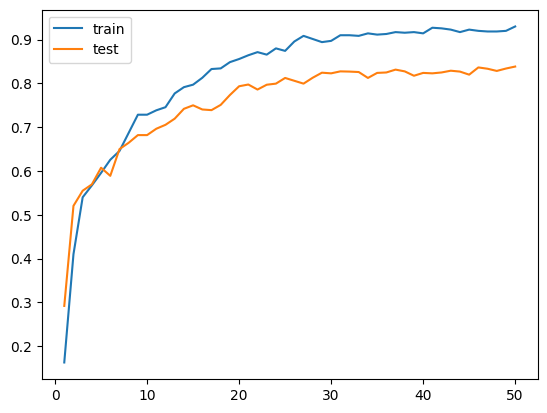

train best: 0.93
test best:  0.8385
alpha = 0
dp = 0.1


In [188]:
ALPHA = 0
DP = 0.1
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [11:28<00:00, 13.77s/it]


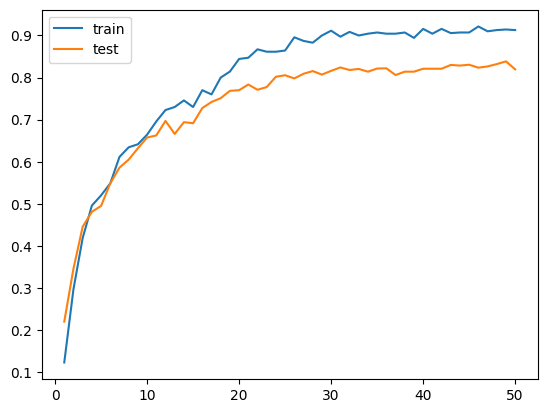

train best: 0.9214285714285714
test best:  0.8385
alpha = 0
dp = 0.15


In [189]:
ALPHA = 0
DP = 0.15
demo(SGD, samples=2000, epochs=50)

optimiser is SGD


100%|██████████| 50/50 [11:44<00:00, 14.09s/it]


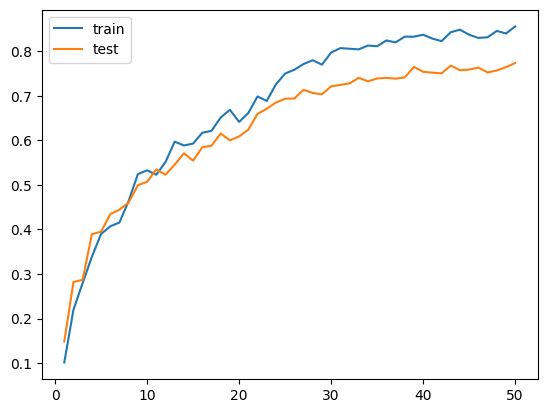

train best: 0.8557142857142858
test best:  0.7735
alpha = 0
dp = 0.2


In [190]:
ALPHA = 0
DP = 0.2
demo(SGD, samples=2000, epochs=50)